# Improts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import pickle
import gc

In [2]:
def augment_probs(mydf):
    info = {}
    for var in mydf.columns:
        if var in ['ID_code', 'target']:
            continue
        IQR = mydf[var].quantile([0.75]).values - mydf[var].quantile([0.25]).values 
        n = mydf.shape[0] 
        bin_size = 2.5 * IQR / (n ** (1/3)) 
        bin_number = int((mydf[var].max() - mydf[var].min())/bin_size)
        key = var
        mydf[key] = pd.cut(mydf[var], bins = bin_number, labels = range(bin_number)).astype('float')
        info[var] = {
            'bin' : bin_number,
        }
    return mydf, info

def test_augment_probs(mydf, info):
    for var in mydf.columns:
        if var in ['ID_code', 'target']:
            continue
        bin_number = info[var]['bin']
        key = var
        mydf[key] = pd.cut(mydf[var], bins = bin_number, labels = range(bin_number)).astype('float')
    return mydf

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df, info = augment_probs(train_df)

In [4]:
test_df = test_augment_probs(test_df, info)

In [5]:
X_train = train_df.drop(['ID_code', 'target'], axis=1)
y_train = train_df.target
Xtr, Xval, ytr, yval  = train_test_split(X_train, y_train, test_size = 0.05)

In [6]:
def save_model(models, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(models, handle)
        
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)
    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

def lgb_trainer(X, y, params, n_folds):
    skf = StratifiedKFold(n_splits=n_folds)
    models = []
    for train_idx, test_idx in skf.split(X.values, y.values):
            gc.collect()
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = augment(X_train.values, y_train.values)
            X_tr = pd.DataFrame(X_tr)
            trn_data = lgb.Dataset(X_tr, label=y_tr)
            test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
            model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
            models.append(model_lgb)
            auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))
    return models

def lgb_trainer_no_aug(X, y, params, n_folds):
    skf = StratifiedKFold(n_splits=n_folds)
    models = []
    for train_idx, test_idx in skf.split(X.values, y.values):
            gc.collect()
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = X_train.values, y_train.values
            X_tr = pd.DataFrame(X_tr)
            trn_data = lgb.Dataset(X_tr, label=y_tr)
            test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
            model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
            models.append(model_lgb)
            auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))
    return models

def test(X, y, models):
    preds = pd.DataFrame({})
    for i, model in enumerate(models):
        preds[str(i)] = model.predict(X)
        print(f"Fold: {i} \t Score: {roc_auc_score(y, preds[str(i)].values)}")
    averaged_preds = preds.mean(axis=1)
    print(f"Score: {roc_auc_score(y, averaged_preds)}")
    return averaged_preds, preds

In [7]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
}

In [8]:
first_models_v = lgb_trainer(Xtr, ytr, param, n_folds = 10)

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.91183	valid_1's auc: 0.897869
[10000]	training's auc: 0.921669	valid_1's auc: 0.901173
[15000]	training's auc: 0.928897	valid_1's auc: 0.901358
Early stopping, best iteration is:
[14144]	training's auc: 0.927725	valid_1's auc: 0.901507
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912023	valid_1's auc: 0.897901
[10000]	training's auc: 0.92183	valid_1's auc: 0.901386
[15000]	training's auc: 0.929083	valid_1's auc: 0.901826
Early stopping, best iteration is:
[13839]	training's auc: 0.927496	valid_1's auc: 0.901932
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.911711	valid_1's auc: 0.901862
[10000]	training's auc: 0.921484	valid_1's auc: 0.905561
[15000]	training's auc: 0.928713	valid_1's auc: 0.905652
Early stopping, best iteration is:
[14196]	training's auc: 0.92762	valid_1's auc: 0.905748
Training until validation

In [9]:
first_models_no_aug = lgb_trainer_no_aug(Xtr, ytr, param, n_folds = 10)

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924643	valid_1's auc: 0.898444
[10000]	training's auc: 0.939831	valid_1's auc: 0.900718
[15000]	training's auc: 0.952072	valid_1's auc: 0.900695
Early stopping, best iteration is:
[13556]	training's auc: 0.94873	valid_1's auc: 0.900915
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924541	valid_1's auc: 0.898586
[10000]	training's auc: 0.939746	valid_1's auc: 0.900795
Early stopping, best iteration is:
[10517]	training's auc: 0.941113	valid_1's auc: 0.900885
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924259	valid_1's auc: 0.903232
[10000]	training's auc: 0.939579	valid_1's auc: 0.905256
Early stopping, best iteration is:
[9812]	training's auc: 0.939071	valid_1's auc: 0.905331
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.925395	valid_1's auc: 0.891711
[10000]	training's

In [10]:
q, w = test(Xval, yval, first_models_v)

Fold: 0 	 Score: 0.8971929743353916
Fold: 1 	 Score: 0.897355430502694
Fold: 2 	 Score: 0.8982592816083184
Fold: 3 	 Score: 0.8972756000116726
Fold: 4 	 Score: 0.8971582022307591
Fold: 5 	 Score: 0.8977126551789025
Fold: 6 	 Score: 0.8964722637679925
Fold: 7 	 Score: 0.8974089862522726
Fold: 8 	 Score: 0.8970376738423544
Fold: 9 	 Score: 0.8966294649870062
Score: 0.8980648485216433


In [11]:
q, w = test(Xval, yval, first_models_no_aug)

Fold: 0 	 Score: 0.8951358297915539
Fold: 1 	 Score: 0.8957528948895181
Fold: 2 	 Score: 0.895917475397618
Fold: 3 	 Score: 0.8952897885956664
Fold: 4 	 Score: 0.8952024670081488
Fold: 5 	 Score: 0.8962828620147851
Fold: 6 	 Score: 0.8967149976559576
Fold: 7 	 Score: 0.8962599414956546
Fold: 8 	 Score: 0.8965677472964688
Fold: 9 	 Score: 0.8953598918419836
Score: 0.8966730698770599


In [15]:
Xval.shape

(10000, 202)

In [20]:
q.isna().any()

False

In [16]:
q.shape

(10000,)

In [22]:
Xval['preds'] = q.values
Xval['target'] = yval

/home/timetraveller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/timetraveller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
Xval[Xval.target == 1][Xval.preds < 0.5]

/home/timetraveller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  var_9  \
51384    35.0   66.0   68.0   62.0   40.0   27.0   62.0   38.0   54.0   49.0   
137302   60.0   39.0   66.0   58.0   56.0   56.0   44.0   31.0   73.0   59.0   
173590   52.0   32.0   78.0   18.0   69.0   57.0   20.0   51.0   53.0   61.0   
194932   66.0   83.0   43.0   56.0   50.0   72.0   70.0   27.0   52.0   44.0   
4516     53.0   60.0   34.0   46.0   71.0   65.0   59.0   49.0   38.0   53.0   
199578   55.0   43.0   20.0   52.0   62.0   34.0   60.0   25.0   53.0   61.0   
99587    48.0   60.0   60.0   48.0   40.0   80.0   92.0   45.0   50.0   62.0   
91339    82.0   43.0   36.0   51.0   46.0   62.0   36.0   61.0   32.0   14.0   
110009   36.0   53.0   54.0   67.0   50.0   34.0   69.0   56.0   26.0   57.0   
124994   47.0   62.0   19.0   77.0   45.0   35.0   25.0   54.0   33.0   46.0   
123812   56.0   39.0   49.0   38.0   77.0   71.0   67.0   33.0   54.0   41.0   
117120   69.0   49.0   61.0   59.0   58.0   32.0   73.0   57.0   17.0   56.0   
164141   47.0   69.0   36.0   53.0   44.0   38.0   33.0   30.0   44.0   39.0   
72756    61.0   47.0   81.0   41.0   38.0   25.0   53.0   58.0   31.0   57.0   
151815   69.0   44.0   64.0   31.0   49.0   51.0   56.0   37.0   28.0   28.0   
51079    39.0   39.0   66.0   38.0   68.0   61.0   63.0   65.0   56.0   44.0   
62317    92.0   51.0   40.0   25.0   48.0   26.0   67.0   25.0   45.0   47.0   
160665   79.0   25.0   57.0   93.0   73.0   43.0   62.0   46.0   51.0   30.0   
126525   85.0   73.0   44.0   62.0   48.0   58.0   38.0   37.0   33.0   56.0   
115909   58.0   77.0   88.0   41.0   81.0   55.0   61.0   63.0   36.0   24.0   
19214    37.0   58.0   45.0   44.0   74.0   72.0   60.0   39.0   46.0   29.0   
30185    84.0   57.0   42.0   51.0   67.0   65.0   63.0   61.0   63.0   36.0   
144297   39.0   33.0   35.0   38.0   44.0   75.0   82.0   61.0   34.0   37.0   
192533   48.0   66.0   32.0   44.0   58.0   29.0   61.0   85.0   26.0   44.0   
52325    90.0   44.0   39.0   45.0   51.0   55.0   88.0   60.0   70.0   52.0   
172828   48.0   56.0   63.0   52.0   44.0   31.0   27.0   69.0   41.0   29.0   
43138    65.0   38.0   73.0   75.0   43.0   28.0   79.0   31.0   47.0   57.0   
8312     76.0   75.0   73.0   10.0   51.0   64.0   52.0   69.0   69.0   55.0   
178110   41.0   32.0   62.0   37.0   54.0   32.0   55.0   64.0   31.0   27.0   
138924   60.0   76.0   46.0   65.0   76.0   28.0   65.0   74.0   64.0   23.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
132431   27.0   50.0   32.0   37.0   77.0   58.0   92.0   49.0   47.0   33.0   
133730   54.0   38.0   34.0   62.0   56.0   82.0   48.0   38.0   43.0   11.0   
96877    41.0   68.0   53.0   58.0   39.0   24.0   48.0   58.0   43.0   37.0   
37019    36.0   57.0   51.0   82.0   51.0   66.0   64.0   42.0   53.0   43.0   
25188    77.0   75.0   81.0   31.0   72.0   69.0   47.0   72.0   68.0   62.0   
177936   42.0   63.0   83.0   80.0   57.0   65.0   17.0   49.0   61.0   62.0   
74148    77.0   64.0   84.0   74.0   46.0   49.0   29.0   48.0   45.0   63.0   
64355    23.0   26.0   70.0   51.0   81.0   59.0   64.0   45.0   56.0   54.0   
61838    47.0   50.0   37.0   78.0   45.0   85.0   40.0   74.0   45.0   45.0   
111905   45.0   36.0   50.0   73.0   45.0   67.0   50.0   25.0   25.0   39.0   
186654   38.0   48.0   86.0   69.0   63.0   65.0   63.0   71.0   54.0   40.0   
78560    40.0   48.0   29.0   32.0   82.0   33.0   40.0   61.0   72.0   39.0   
69650    35.0   47.0   39.0   51.0   77.0   41.0   29.0   77.0   67.0   56.0   
77880    42.0   63.0   33.0   59.0   44.0   43.0   42.0   53.0   36.0   31.0   
2111     70.0   60.0   56.0   71.0   45.0   40.0   82.0   53.0   70.0   35.0   
37571    80.0   57.0   30.0   52.0   46.0   44.0   57.0   42.0   26.0   52.0   
151649   31.0   53.0   65.0   46.0   59.0   33.0   65.0   47.0   24.0   38.0   
17962    67.0   64.0   51.0   32.0   45.0   88.0   27.0   55.0   58.0   38.0   
49011   

In [28]:
Xval[Xval.target == 0][Xval.preds > 0.5]

/home/timetraveller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  var_9  \
93500    58.0   61.0   53.0   47.0   31.0   87.0   35.0   55.0   66.0   38.0   
134249   79.0   75.0   38.0   61.0   76.0   45.0   87.0   36.0   18.0   62.0   
118547   72.0   61.0   48.0   61.0   71.0   55.0   52.0   59.0   49.0   26.0   
84797    47.0   73.0   53.0   76.0   56.0   84.0   77.0   44.0   38.0   49.0   
136967   57.0   46.0   79.0   75.0   55.0   52.0   53.0   58.0   34.0   27.0   
64371    61.0   56.0   87.0   67.0   37.0   55.0   72.0   59.0   39.0    8.0   
168063   48.0   23.0   45.0   74.0   61.0   52.0   68.0   24.0   53.0   18.0   
37854    73.0   65.0   48.0   66.0   54.0   53.0   59.0   61.0   67.0   31.0   
173255   37.0   48.0   38.0   57.0   50.0   35.0   41.0   28.0   39.0   47.0   
53934    70.0   21.0   48.0   61.0   69.0   34.0   64.0   24.0   39.0   37.0   
124195   45.0   77.0   59.0   26.0   56.0   52.0   65.0   51.0   53.0   53.0   
164799   57.0   32.0   48.0   64.0   54.0   64.0   52.0   58.0   52.0    9.0   
116855   85.0   66.0   75.0   63.0   75.0   60.0   51.0   54.0   59.0   48.0   
141109   41.0   87.0   45.0   60.0   77.0   51.0   57.0   74.0   57.0   41.0   
76362    61.0   81.0   41.0   57.0   69.0   60.0   57.0   43.0   70.0   41.0   
41944    88.0   66.0   69.0   36.0   83.0   41.0   90.0   76.0   54.0   27.0   
92693    38.0   57.0   50.0   82.0   56.0   31.0   73.0   34.0   71.0   28.0   
96409    58.0   79.0   89.0   50.0   67.0   67.0   63.0   34.0   17.0   29.0   
67131    66.0   54.0   89.0   49.0   41.0   51.0   46.0   49.0   24.0   45.0   
18448    41.0   76.0   34.0   39.0   80.0   67.0   56.0   23.0   63.0   42.0   
69633    69.0   41.0   48.0   66.0   51.0   47.0   29.0   66.0   36.0   30.0   
110537   21.0   48.0   47.0   33.0   74.0   39.0   64.0   50.0   57.0   33.0   
87463    77.0   39.0   86.0   39.0   68.0   58.0   47.0   50.0   43.0   29.0   
19674    62.0   48.0   34.0   48.0   57.0   76.0   65.0   64.0   67.0   73.0   
39729    77.0   34.0   35.0   36.0   57.0   41.0   56.0   66.0   66.0   48.0   
66515    74.0   59.0   41.0   69.0   44.0   40.0   51.0   26.0   66.0   54.0   
62438    76.0   54.0   62.0   90.0   43.0   43.0   81.0   57.0   49.0   43.0   
156342   74.0   63.0   55.0   24.0   60.0   50.0   73.0   56.0   49.0   42.0   
100450   49.0   30.0   50.0   71.0   44.0   53.0   60.0   54.0   37.0   23.0   
36100    60.0   56.0   67.0   39.0   29.0   43.0   39.0   31.0   76.0   56.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
157893   43.0   86.0   57.0   49.0   69.0   76.0   79.0   65.0   38.0   50.0   
126753   55.0   69.0   61.0   77.0   89.0   85.0   54.0   49.0   50.0   23.0   
38385    89.0   53.0   29.0   56.0   80.0   49.0   51.0   58.0   39.0   10.0   
37479    81.0   89.0   28.0   39.0   81.0   69.0   58.0   60.0   43.0   60.0   
58236    36.0   59.0   57.0   54.0   46.0   28.0   69.0   39.0   51.0   27.0   
188003   96.0   78.0   82.0   52.0   53.0   56.0   64.0   34.0   47.0   27.0   
125618   57.0   51.0   73.0   36.0   59.0   53.0   86.0   62.0   25.0   61.0   
187488   63.0   71.0   65.0   61.0   92.0   56.0   98.0   48.0   76.0   63.0   
110834   68.0   55.0   54.0   45.0   31.0   67.0   63.0   61.0   39.0   49.0   
96613    98.0   62.0   57.0   35.0   56.0   63.0   54.0   31.0   41.0   41.0   
185776   45.0   44.0   69.0   46.0   47.0   71.0   49.0   57.0   61.0    5.0   
55672    18.0   47.0   91.0   49.0   61.0   68.0   75.0   57.0   77.0   60.0   
195296   67.0   78.0   47.0   58.0   56.0   51.0   84.0   53.0   68.0    9.0   
197168   72.0   71.0   63.0   42.0   56.0   64.0   68.0   47.0   58.0   57.0   
121006   90.0   63.0   77.0   68.0   55.0   49.0   53.0   46.0   37.0   20.0   
132659   56.0   82.0   90.0   39.0   63.0   38.0   36.0   61.0   47.0   55.0   
151701   39.0   38.0   69.0   49.0   52.0   68.0   77.0   26.0   38.0   38.0   
20341    63.0   65.0   35.0   58.0   52.0   58.0   62.0   43.0   34.0    6.0   
14719   

# Test

In [4]:
from scipy.special import erfc
import scipy
plt.style.use('seaborn')

In [10]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [6]:
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   ...     var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266   ...      4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338   ...      7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155   ...      2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250   ...      4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514   ...     -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

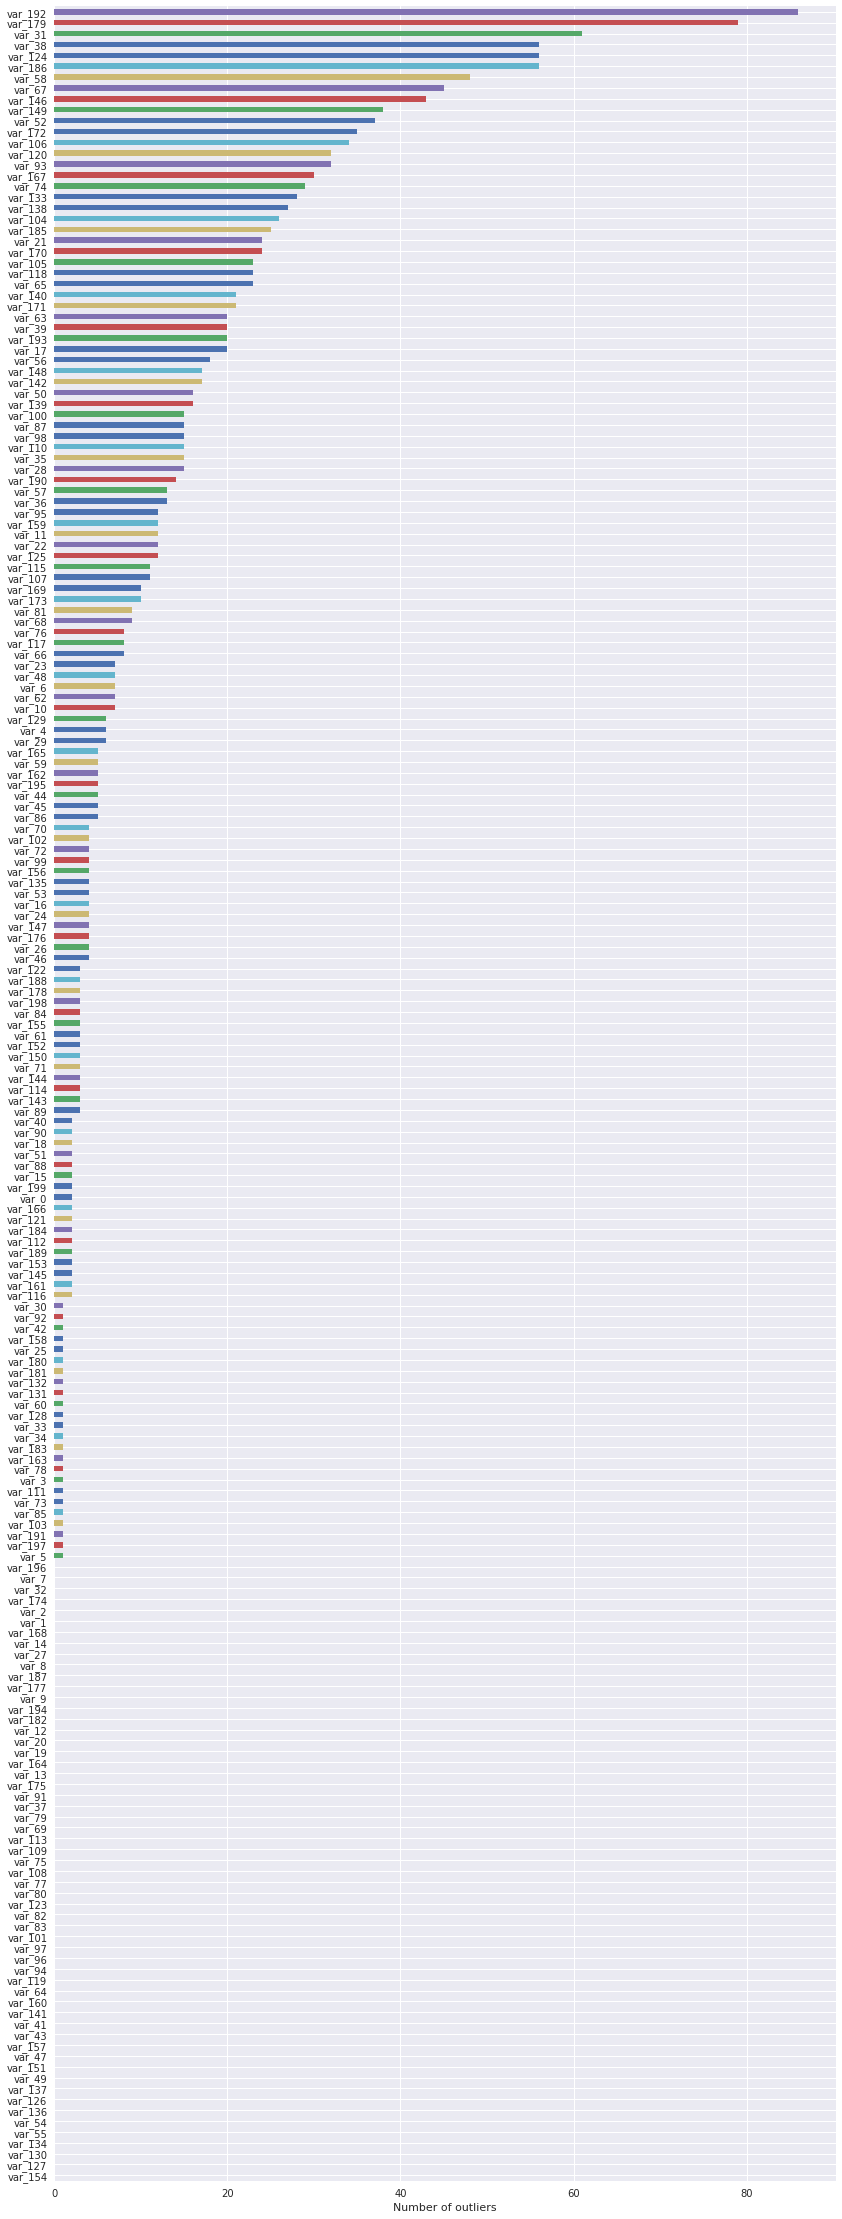

In [7]:
outliers = dict()
for col in [col for col in train_df.columns if col not in ['ID_code', 'target']]:
    outliers[col] = train_df[chauvenet(train_df[col].values)].shape[0]
outliers = pd.Series(outliers)
outliers.sort_values().plot(figsize=(14, 40), kind='barh').set_xlabel('Number of outliers');

MemoryError: 